In [1]:

import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


#train and test data directory
data_dir = "C:/Users/augus/OneDrive/Skrivebord/Januar projekt 2023/DTU-Eksame-projekt-KID/Data"
test_data_dir = "C:/Users/augus/OneDrive/Skrivebord/Januar projekt 2023/DTU-Eksame-projekt-KID/valid"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((28,28)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((28,28)),transforms.ToTensor()
]))

In [2]:

#Check if the dataset has categories that correspond with the CNN
print(dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Minus', 'Multiplication', 'Plus']


Label : 0


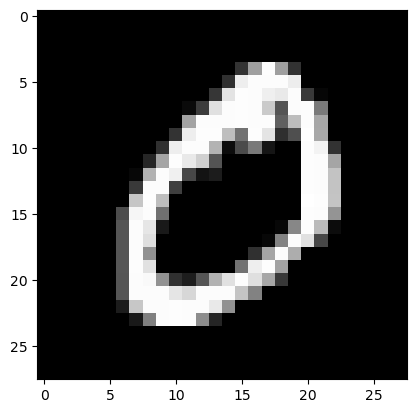

In [3]:

#Check if the images from the dataset has been loaded properly
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [4]:

#Splitting data and prepare batches


batch_size = 128
val_size = 2000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : ?
#Length of Validation Data : ?

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 58299
Length of Validation Data : 2000


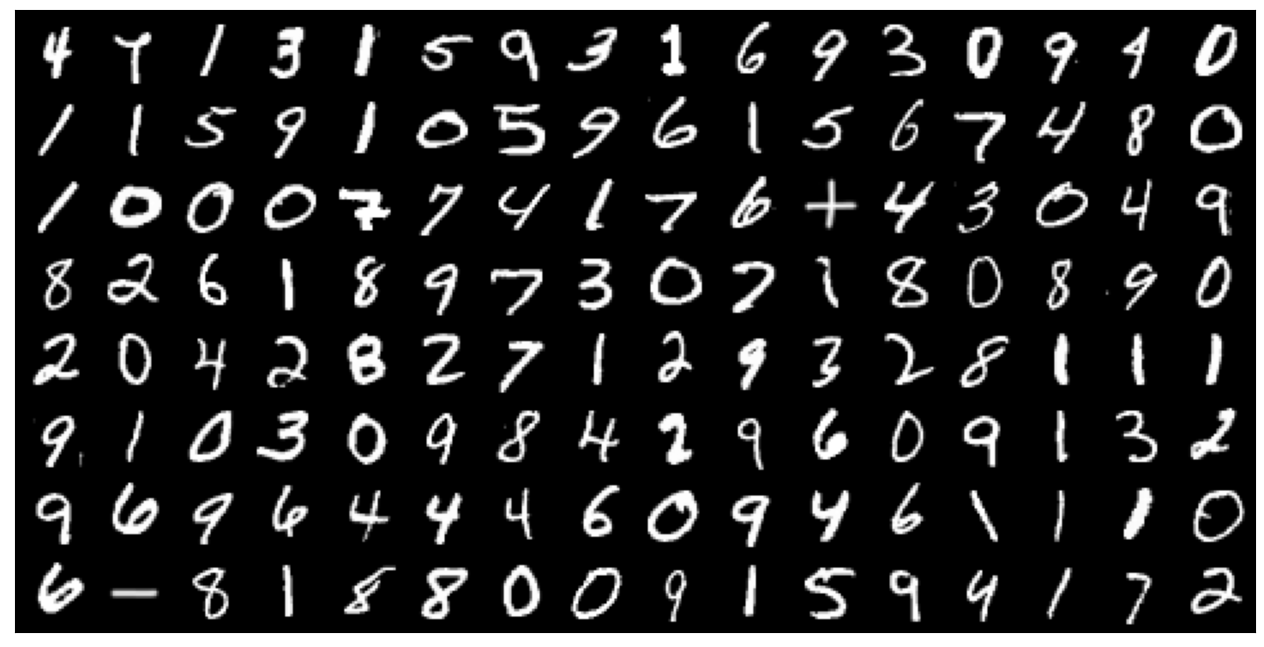

In [5]:
#Visualize and check if the sample is satisfying


def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [6]:
#Model for image classification


class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [7]:

#The CNN
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(2, 10, kernel_size = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(10,49, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(49, 196, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(196 ,196, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
          
            nn.Flatten(),
            nn.Linear(784,392),
            nn.ReLU(),
            nn.Linear(392,196),
            nn.ReLU(),
            nn.Linear(196,13)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [8]:
#Training and Eval parameters

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history


In [9]:
#Training
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

#This should save the model, so we can use it to recognize a new picture

NameError: name 'model' is not defined

In [ ]:

#Graph
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

The two following codes are guesses on how to load and apply the CNN on an image.

In [ ]:
#Loading model and using it on a new picture to recognize and save the symbols in the order they are read
model = model.load_state_dict(torch.load('C:\Users\augus\OneDrive\Skrivebord\Januar projekt 2023\DTU-Eksame-projekt-KID\Saved CNN'))

#Something to load the image
img = Image.open(...)

def predict_digit(img):
    #resize image to 28x28 pixels
    img = img.resize((28,28))
    #convert rgb to grayscale
    img = img.convert('L')
    img = np.array(img)
    #reshaping to support our model input and normalizing
    img = img.reshape(1,28,28,1)
    img = img/255.0
    #predicting the class
    res = model.predict([img])[0]
    return np.argmax(res), max(res)

In [ ]:
# Create the model
model = MyModel()

# Load state_dict
model.load_state_dict(torch.load(...))

# Create the preprocessing transformation here
transform = transforms.ToTensor()

# load your image(s)
img = Image.open(...)

# Transform
input = transform(img)

# unsqueeze batch dimension, in case you are dealing with a single image
input = input.unsquueeze(0)

# Set model to eval
model.eval()

# Get prediction
output = model(input)